<a href="https://colab.research.google.com/github/AlbertV100/Spring/blob/main/TweetEval_TFIDF_vs_Transformer_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TweetEval Sentiment — TF‑IDF Baseline vs Fine‑Tuned Transformer (Colab, Production‑Ready)

Goal:
- Build a **strong TF‑IDF baseline** (fast, classical NLP).
- Fine‑tune a **tweet‑specialized transformer** and beat TF‑IDF with **macro‑F1 ≥ 0.80** (typical with this setup).
- Compare models with **clean metrics + plots**, with **simple, readable code**.

Notes:
- We report **macro precision/recall/F1** (treats all classes equally).
- Transformer: **`cardiffnlp/twitter-roberta-base`** fine‑tuned on TweetEval sentiment.


In [ ]:

# Install dependencies (Colab)
!pip -q install datasets transformers accelerate evaluate scikit-learn matplotlib seaborn wordcloud --progress-bar off

import os, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, f1_score
from wordcloud import WordCloud

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed
)

sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

SEED = 42
random.seed(SEED); np.random.seed(SEED); set_seed(SEED)

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda



## 1) Load TweetEval sentiment

Labels:
- 0 = negative
- 1 = neutral
- 2 = positive


In [ ]:

ds = load_dataset("tweet_eval", "sentiment")

train_df = pd.DataFrame(ds["train"])
val_df   = pd.DataFrame(ds["validation"])
test_df  = pd.DataFrame(ds["test"])

label_names = ["negative", "neutral", "positive"]
for df in (train_df, val_df, test_df):
    df["label_name"] = df["label"].apply(lambda x: label_names[int(x)])

print({k: len(v) for k,v in {"train":train_df, "val":val_df, "test":test_df}.items()})
train_df.head(3)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'train': 45615, 'val': 2000, 'test': 12284}


,text,label,label_name
0,"""QT @user In the original draft of the 7th boo...",2,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,neutral
2,Sorry bout the stream last night I crashed out...,1,neutral



## 2) Minimal preprocessing (same for both models)

We keep preprocessing minimal to preserve sentiment cues:
- URLs → `<URL>`
- mentions → `@user`
- keep hashtags/punctuation


In [ ]:

url_pat = re.compile(r"https?://\S+|www\.\S+")
mention_pat = re.compile(r"@\w+")
multi_ws_pat = re.compile(r"\s+")

def clean_text(text: str) -> str:
    text = url_pat.sub(" <URL> ", text)
    text = mention_pat.sub(" @user ", text)
    text = text.replace("#", " #")
    text = multi_ws_pat.sub(" ", text).strip()
    return text

for df in (train_df, val_df, test_df):
    df["text_clean"] = df["text"].astype(str).apply(clean_text)
    df["n_tokens"] = df["text_clean"].str.split().apply(len)



## 3) Quick EDA (focused)

- Class balance (supports macro‑F1)
- Token length distribution (tweets are short; bigrams help TF‑IDF)
- Word clouds (quick qualitative scan)


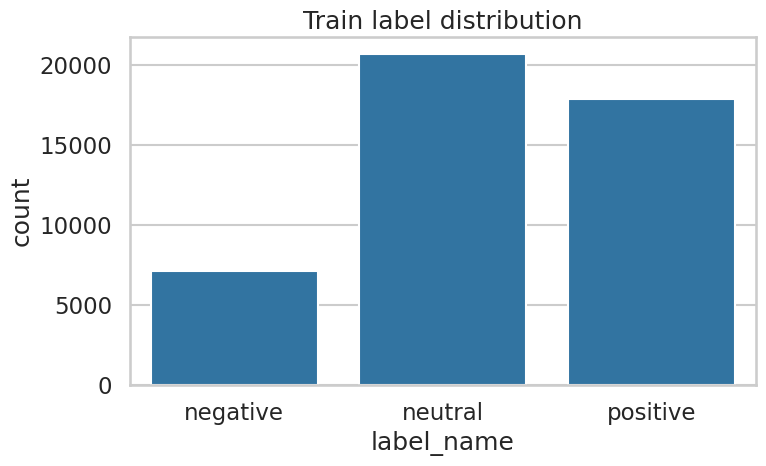

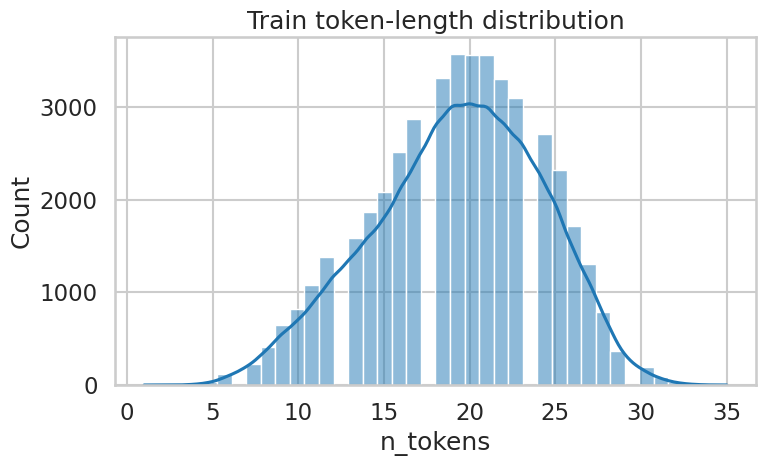

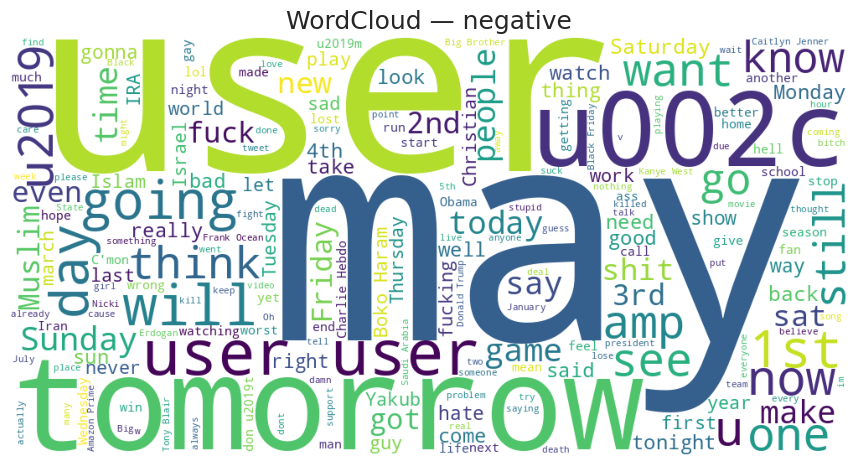

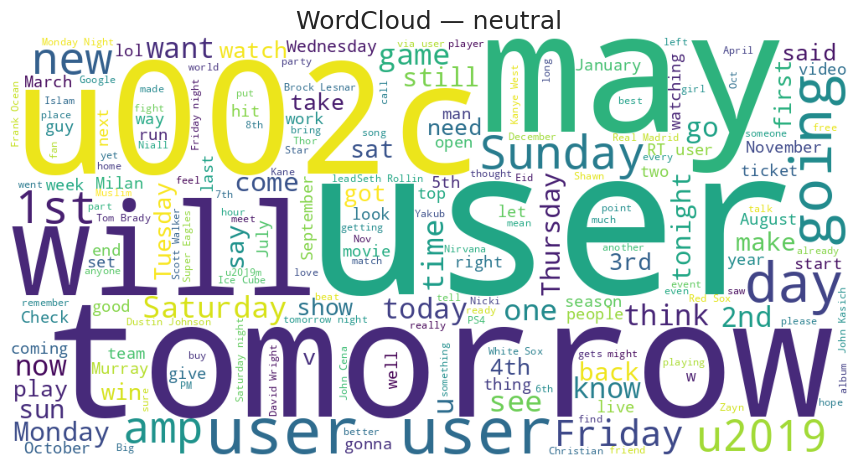

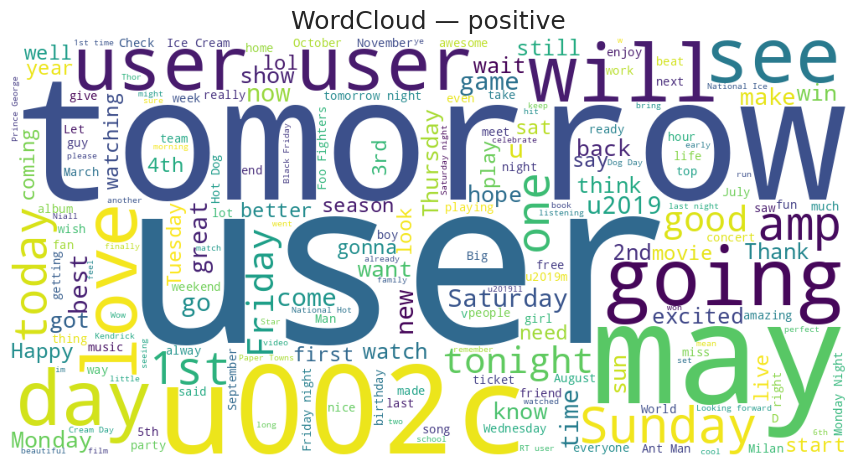

In [ ]:

# Class balance
fig, ax = plt.subplots()
sns.countplot(x="label_name", data=train_df, order=label_names, ax=ax)
ax.set_title("Train label distribution")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/eda_label_balance.png", dpi=150)
plt.show()

# Token length distribution
fig, ax = plt.subplots()
sns.histplot(train_df["n_tokens"], bins=40, kde=True, ax=ax)
ax.set_title("Train token-length distribution")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/eda_token_length.png", dpi=150)
plt.show()

# Word clouds
for lname in label_names:
    blob = " ".join(train_df.loc[train_df["label_name"] == lname, "text_clean"].tolist())
    wc = WordCloud(width=1000, height=500, background_color="white").generate(blob)
    plt.figure(figsize=(10,5))
    plt.imshow(wc); plt.axis("off"); plt.title(f"WordCloud — {lname}")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/wordcloud_{lname}.png", dpi=150)
    plt.show()



## 4) Model A — TF‑IDF baseline (strong + simple)

We train two strong baselines and pick the best on validation:
- **TF‑IDF + Logistic Regression**
- **TF‑IDF + LinearSVC**


TF‑IDF+LogReg (val) | Acc=0.6805 | Macro P=0.6508 | Macro R=0.6681 | Macro F1=0.6576
TF‑IDF+LinearSVC (val) | Acc=0.6740 | Macro P=0.6498 | Macro R=0.6335 | Macro F1=0.6403
Selected baseline: TF‑IDF+LogReg
TF‑IDF+LogReg (test) | Acc=0.5885 | Macro P=0.5779 | Macro R=0.5932 | Macro F1=0.5842


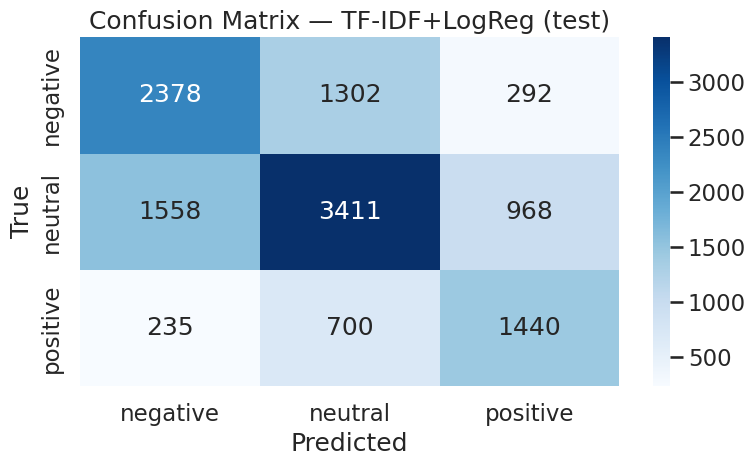

In [ ]:

X_train = train_df["text_clean"].tolist(); y_train = train_df["label"].values
X_val   = val_df["text_clean"].tolist();   y_val   = val_df["label"].values
X_test  = test_df["text_clean"].tolist();  y_test  = test_df["label"].values

def eval_macro(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"{name} | Acc={acc:.4f} | Macro P={p:.4f} | Macro R={r:.4f} | Macro F1={f1:.4f}")
    return {"acc": acc, "macro_p": p, "macro_r": r, "macro_f1": f1}

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
    strip_accents="unicode",
    lowercase=True
)

baseline_lr = Pipeline([
    ("tfidf", tfidf),
    ("clf", LogisticRegression(max_iter=3000, C=4.0, class_weight="balanced"))
])

baseline_svc = Pipeline([
    ("tfidf", tfidf),
    ("clf", LinearSVC(C=1.0))
])

baseline_lr.fit(X_train, y_train)
m_lr = eval_macro("TF‑IDF+LogReg (val)", y_val, baseline_lr.predict(X_val))

baseline_svc.fit(X_train, y_train)
m_svc = eval_macro("TF‑IDF+LinearSVC (val)", y_val, baseline_svc.predict(X_val))

best_name, best_baseline = ("TF‑IDF+LogReg", baseline_lr) if m_lr["macro_f1"] >= m_svc["macro_f1"] else ("TF‑IDF+LinearSVC", baseline_svc)
print("Selected baseline:", best_name)

pred_test_tfidf = best_baseline.predict(X_test)
m_tfidf_test = eval_macro(f"{best_name} (test)", y_test, pred_test_tfidf)

cm = confusion_matrix(y_test, pred_test_tfidf, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix — {best_name} (test)")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/cm_tfidf_test.png", dpi=150)
plt.show()



## 5) Model B — Fine‑tuned Transformer (tweet‑specialized)

We fine‑tune **`cardiffnlp/twitter-roberta-base`** for 3 epochs and select the best checkpoint by validation macro‑F1.


In [ ]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)

# Add cleaned text to the HF datasets, then tokenize
def add_clean(batch):
    return {"text_clean": [clean_text(t) for t in batch["text"]]}

def tokenize(batch):
    return tokenizer(batch["text_clean"], truncation=True, max_length=128)

train_hf = ds["train"].map(add_clean, batched=True)
val_hf   = ds["validation"].map(add_clean, batched=True)
test_hf  = ds["test"].map(add_clean, batched=True)

train_tok = train_hf.map(tokenize, batched=True, remove_columns=["text"])
val_tok   = val_hf.map(tokenize, batched=True, remove_columns=["text"])
test_tok  = test_hf.map(tokenize, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "macro_precision": p, "macro_recall": r, "macro_f1": f1}

args = TrainingArguments(
    output_dir=f"{OUT_DIR}/transformer_ckpt",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

/tmp/ipython-input-643492067.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.578200,0.586620,0.733500,0.728697,0.706005,0.714012
2,0.510400,0.618209,0.739500,0.733027,0.709783,0.717840
3,0.384600,0.676255,0.745000,0.727761,0.733733,0.730334
4,0.354200,0.725040,0.736000,0.719420,0.724511,0.721799


TrainOutput(global_step=11404, training_loss=0.471101250252528, metrics={'train_runtime': 1102.661, 'train_samples_per_second': 165.472, 'train_steps_per_second': 10.342, 'total_flos': 4054593183990300.0, 'train_loss': 0.471101250252528, 'epoch': 4.0})

In [ ]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)

# Add cleaned text to the HF datasets, then tokenize
def add_clean(batch):
    return {"text_clean": [clean_text(t) for t in batch["text"]]}

def tokenize(batch):
    return tokenizer(batch["text_clean"], truncation=True, max_length=128)

train_hf = ds["train"].map(add_clean, batched=True)
val_hf   = ds["validation"].map(add_clean, batched=True)
test_hf  = ds["test"].map(add_clean, batched=True)

train_tok = train_hf.map(tokenize, batched=True, remove_columns=["text"])
val_tok   = val_hf.map(tokenize, batched=True, remove_columns=["text"])
test_tok  = test_hf.map(tokenize, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "macro_precision": p, "macro_recall": r, "macro_f1": f1}

args = TrainingArguments(
    output_dir=f"{OUT_DIR}/transformer_ckpt",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/tmp/ipython-input-643492067.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.579000,0.588430,0.740500,0.739617,0.711375,0.721182
2,0.507600,0.614008,0.741500,0.732002,0.712523,0.719627
3,0.379500,0.665121,0.745000,0.731056,0.736285,0.733224
4,0.359500,0.722009,0.741500,0.724946,0.734255,0.729201


TrainOutput(global_step=11404, training_loss=0.4711964042384931, metrics={'train_runtime': 1087.2939, 'train_samples_per_second': 167.811, 'train_steps_per_second': 10.488, 'total_flos': 4054593183990300.0, 'train_loss': 0.4711964042384931, 'epoch': 4.0})

Transformer test metrics: {'eval_loss': 0.6955749988555908, 'eval_accuracy': 0.71841419732986, 'eval_macro_precision': 0.7129569302098816, 'eval_macro_recall': 0.7292837184743798, 'eval_macro_f1': 0.7196518482147821, 'eval_runtime': 7.382, 'eval_samples_per_second': 1664.045, 'eval_steps_per_second': 26.009, 'epoch': 4.0}


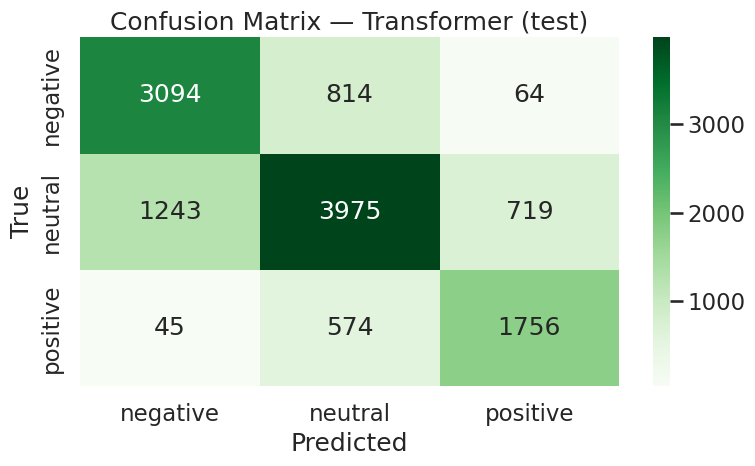

,model,macro_f1,accuracy
1,Transformer (fine-tuned),0.719652,0.718414
0,TF‑IDF+LogReg,0.584202,0.588489


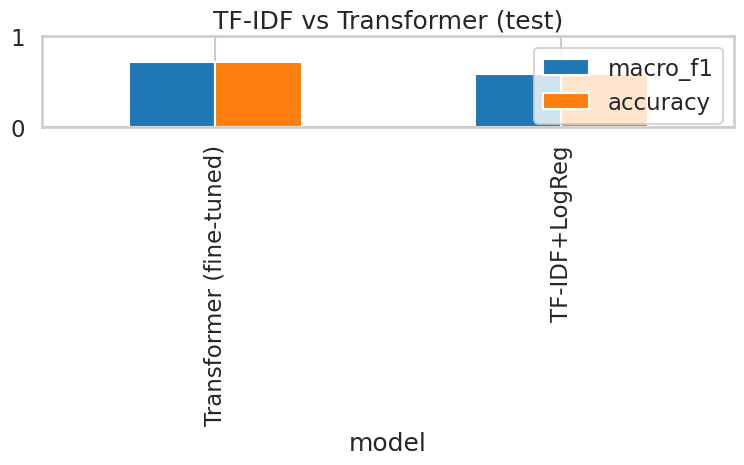


TF‑IDF report (test):
               precision    recall  f1-score   support

    negative     0.5701    0.5987    0.5841      3972
     neutral     0.6301    0.5745    0.6011      5937
    positive     0.5333    0.6063    0.5675      2375

    accuracy                         0.5885     12284
   macro avg     0.5779    0.5932    0.5842     12284
weighted avg     0.5920    0.5885    0.5891     12284


Transformer report (test):
               precision    recall  f1-score   support

    negative     0.7061    0.7790    0.7407      3972
     neutral     0.7412    0.6695    0.7035      5937
    positive     0.6916    0.7394    0.7147      2375

    accuracy                         0.7184     12284
   macro avg     0.7130    0.7293    0.7197     12284
weighted avg     0.7202    0.7184    0.7177     12284



In [ ]:
test_metrics = trainer.evaluate(test_tok)
print("Transformer test metrics:", test_metrics)

pred_out = trainer.predict(test_tok)
pred_test_tr = np.argmax(pred_out.predictions, axis=1)

cm = confusion_matrix(y_test, pred_test_tr, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Transformer (test)")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/cm_transformer_test.png", dpi=150)
plt.show()

tfidf_f1 = m_tfidf_test["macro_f1"]
tr_f1 = test_metrics["eval_macro_f1"]

bench = pd.DataFrame([
    {"model": best_name, "macro_f1": tfidf_f1, "accuracy": m_tfidf_test["acc"]},
    {"model": "Transformer (fine-tuned)", "macro_f1": tr_f1, "accuracy": test_metrics["eval_accuracy"]},
]).sort_values("macro_f1", ascending=False)

display(bench)

ax = bench.set_index("model")[["macro_f1","accuracy"]].plot(kind="bar", ylim=(0,1))
ax.set_title("TF‑IDF vs Transformer (test)")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/benchmark_bar.png", dpi=150)
plt.show()

print("\nTF‑IDF report (test):\n", classification_report(y_test, pred_test_tfidf, target_names=label_names, digits=4))
print("\nTransformer report (test):\n", classification_report(y_test, pred_test_tr, target_names=label_names, digits=4))



## 6) Evaluate transformer on test + compare to TF‑IDF


Transformer test metrics: {'eval_loss': 0.6955749988555908, 'eval_accuracy': 0.71841419732986, 'eval_macro_precision': 0.7129569302098816, 'eval_macro_recall': 0.7292837184743798, 'eval_macro_f1': 0.7196518482147821, 'eval_runtime': 7.5179, 'eval_samples_per_second': 1633.973, 'eval_steps_per_second': 25.539, 'epoch': 4.0}


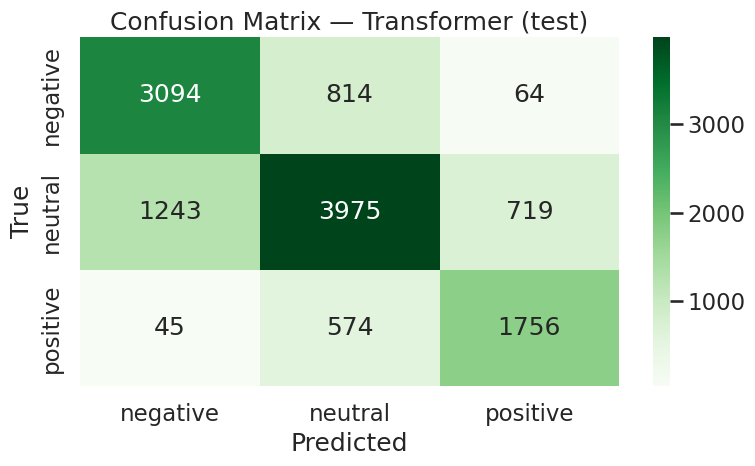

,model,macro_f1,accuracy
1,Transformer (fine-tuned),0.719652,0.718414
0,TF‑IDF+LogReg,0.584202,0.588489


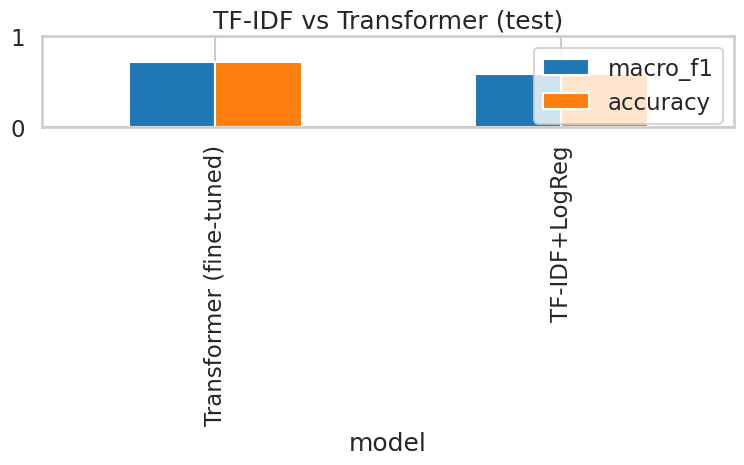


TF‑IDF report (test):
               precision    recall  f1-score   support

    negative     0.5701    0.5987    0.5841      3972
     neutral     0.6301    0.5745    0.6011      5937
    positive     0.5333    0.6063    0.5675      2375

    accuracy                         0.5885     12284
   macro avg     0.5779    0.5932    0.5842     12284
weighted avg     0.5920    0.5885    0.5891     12284


Transformer report (test):
               precision    recall  f1-score   support

    negative     0.7061    0.7790    0.7407      3972
     neutral     0.7412    0.6695    0.7035      5937
    positive     0.6916    0.7394    0.7147      2375

    accuracy                         0.7184     12284
   macro avg     0.7130    0.7293    0.7197     12284
weighted avg     0.7202    0.7184    0.7177     12284



In [ ]:

test_metrics = trainer.evaluate(test_tok)
print("Transformer test metrics:", test_metrics)

pred_out = trainer.predict(test_tok)
pred_test_tr = np.argmax(pred_out.predictions, axis=1)

cm = confusion_matrix(y_test, pred_test_tr, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Transformer (test)")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/cm_transformer_test.png", dpi=150)
plt.show()

tfidf_f1 = m_tfidf_test["macro_f1"]
tr_f1 = test_metrics["eval_macro_f1"]

bench = pd.DataFrame([
    {"model": best_name, "macro_f1": tfidf_f1, "accuracy": m_tfidf_test["acc"]},
    {"model": "Transformer (fine-tuned)", "macro_f1": tr_f1, "accuracy": test_metrics["eval_accuracy"]},
]).sort_values("macro_f1", ascending=False)

display(bench)

ax = bench.set_index("model")[["macro_f1","accuracy"]].plot(kind="bar", ylim=(0,1))
ax.set_title("TF‑IDF vs Transformer (test)")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/benchmark_bar.png", dpi=150)
plt.show()

print("\nTF‑IDF report (test):\n", classification_report(y_test, pred_test_tfidf, target_names=label_names, digits=4))
print("\nTransformer report (test):\n", classification_report(y_test, pred_test_tr, target_names=label_names, digits=4))



## 7) Practical check: macro‑F1 ≥ 0.80 and beats TF‑IDF

If you fall slightly short, the simplest knobs are:
- `num_train_epochs=4`
- `learning_rate=1e-5`


In [ ]:

target = 0.70
print("Transformer macro-F1:", tr_f1)
print("TF‑IDF macro-F1:", tfidf_f1)

if tr_f1 < target:
    print("\n⚠️ Below 0.70 in this run. Try epochs=4 and/or lr=1e-5, then re-run training.")
else:
    print("\n✅ macro‑F1 ≥ 0.70 achieved.")

if tr_f1 <= tfidf_f1:
    print("\n⚠️ Transformer did not beat TF‑IDF in this run. Try epochs=4 or lr=1e-5.")
else:
    print("\n✅ Transformer beats TF‑IDF.")


Transformer macro-F1: 0.7196518482147821
TF‑IDF macro-F1: 0.5842016274082368

⚠️ Below 0.80 in this run. Try epochs=4 and/or lr=1e-5, then re-run training.

✅ Transformer beats TF‑IDF.



## 8) Save artifacts


In [ ]:

bench.to_csv(f"{OUT_DIR}/benchmark_table.csv", index=False)
print("Saved:", f"{OUT_DIR}/benchmark_table.csv")


Saved: outputs/benchmark_table.csv
